In [1]:
import numpy as np
import openslide
import cv2
import PIL.Image as Image
import matplotlib.pyplot as plt
import tqdm
#from skimage import transform
import os

In [2]:
from wsiTile import WSITile
from wsiRegister import WSIRegister
from utility import slide_summary

## Load WSI 

In [3]:
slideHE = openslide.open_slide("/home/filippo/Scrivania/1484/20-1081/HE_2.ndpi")
slideGI = openslide.open_slide("/home/filippo/Scrivania/1484/20-1081/Giemsa.ndpi")

WSI information

In [4]:
print("HE")
_, objectiveHE, dimsHE, factorsHE = slide_summary(slideHE, verbose=True)
print("\nGIESMA")
_, objectiveGI, dimsGI, factorsGI = slide_summary(slideGI, verbose=True)

HE
the objective power is 40
Dimensions are: ((80640, 48384), (40320, 24192), (20160, 12096), (10080, 6048), (5040, 3024), (2520, 1512), (1260, 756), (630, 378), (315, 189))
Factors are: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0)

GIESMA
the objective power is 40
Dimensions are: ((76800, 57600), (38400, 28800), (19200, 14400), (9600, 7200), (4800, 3600), (2400, 1800), (1200, 900), (600, 450), (300, 225))
Factors are: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0)


(480, 800, 3)


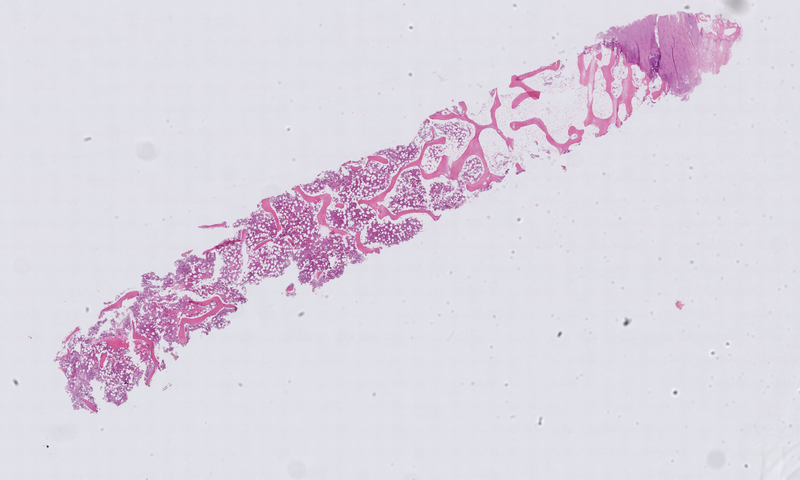

In [5]:
slide_thumb_HE = slideHE.get_thumbnail(size=(800, 800))
print(np.asarray(slide_thumb_HE).shape)
slide_thumb_HE

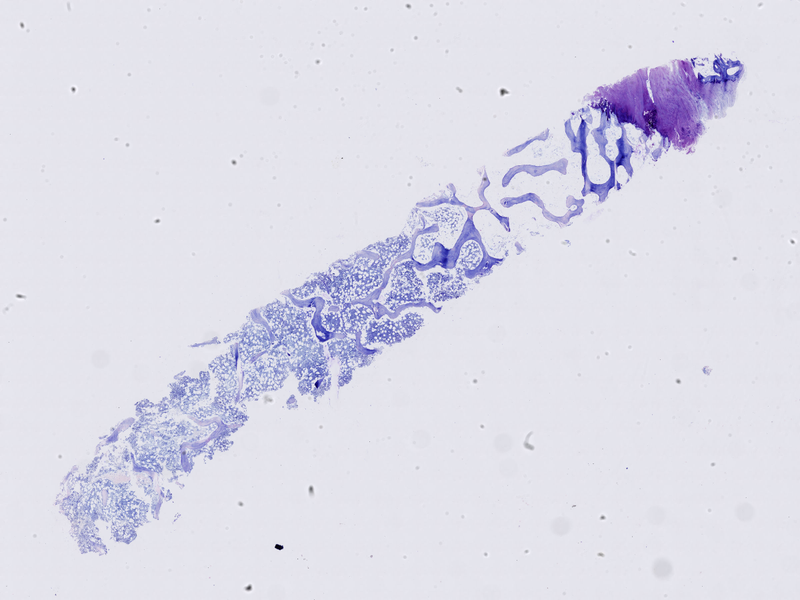

In [6]:
slide_thumb_GI = slideGI.get_thumbnail(size=(800, 800))
slide_thumb_GI

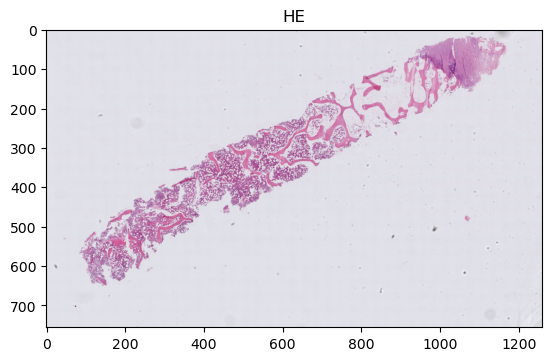

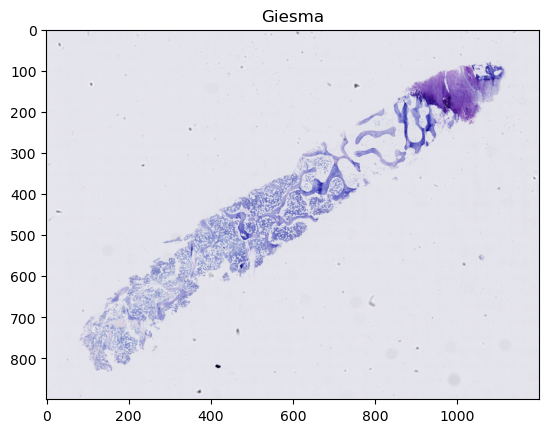

In [7]:
shape = (dimsHE[6][1], dimsHE[6][0])
imgHE = WSITile(slideHE, level=6, top_left_coord=(0, 0), shape=shape)
shape = (dimsGI[6][1], dimsGI[6][0])
imgGI = WSITile(slideGI, level=6, top_left_coord=(0, 0), shape=shape)

plt.imshow(imgHE.tile)
plt.title('HE')
plt.show()

plt.imshow(imgGI.tile)
plt.title('Giesma')
plt.show()

## Create an object WSI_alinger

In [8]:
wsi_reg = WSIRegister(target_slide=slideHE,
                      source_slide=slideGI)

## Stain Deconvolution
extract cytoplasm

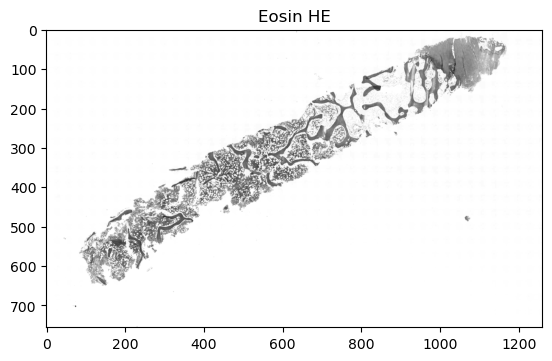

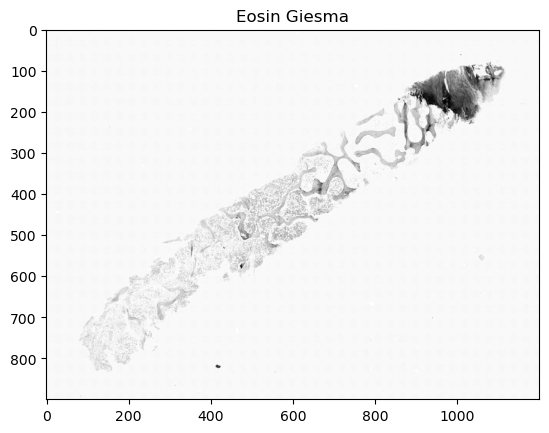

In [9]:
plt.imshow(imgHE.cyto, cmap='gray')
plt.title('Eosin HE')
plt.show()

plt.imshow(imgGI.cyto, cmap='gray')
plt.title('Eosin Giesma')
plt.show()

## SIFT + RANSAC

Number of initial matches: 3763
Number of matches after Lowe's test: 79
Number of matches after RANSAC: 53


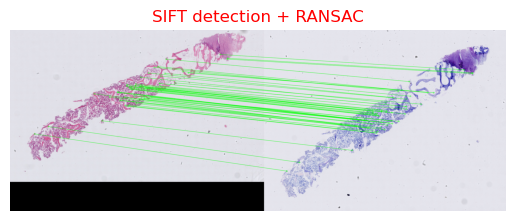

In [10]:
p_points, q_points = wsi_reg.find_matches_with_SIFT_and_RANSAC(target=imgHE.cyto,
                                                               source=imgGI.cyto,
                                                               min_match_count=10,
                                                               verbose=True,
                                                               plot=True,
                                                               target_to_show=imgHE.tile,
                                                               source_to_show=imgGI.tile,
                                                               plot_title='SIFT detection + RANSAC')



p_points, q_points = find_matches(imgHE.cyto, 
                                  imgGI.cyto,
                                  min_match_count=10,
                                  verbose=True,
                                  plot=True,
                                  target_to_show=imgHE.tile,
                                  source_to_show=imgGI.tile,
                                  plot_title='SIFT detection + RANSAC')

## Transformation Parameters: S, R, T

In [11]:
S, R, T = wsi_reg.evaluate_transformation_param(p=p_points,
                                                q=q_points,
                                                verbose=True)

Shape covariance matrix is (2, 2)
det(R) = 0.9999999999999996
S = 0.9855778048492487
R = [[ 0.99365637  0.11245897]
 [-0.11245897  0.99365637]]
T = [-184.38643968   95.87790655]


S, R, T = evaluate_transformation_param(p=p_points,
                                       q=q_points,
                                       verbose=True)

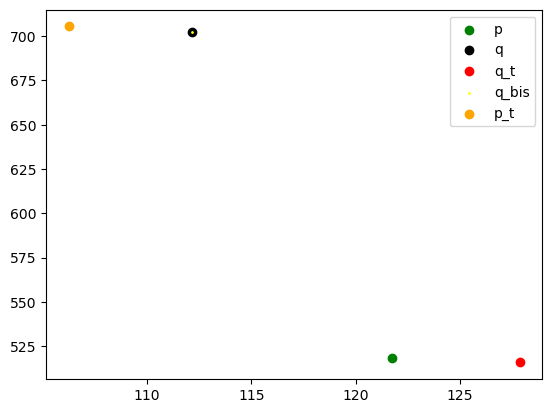

In [12]:
plt.scatter(p_points[0,1], p_points[0,0], label='p', color='green')
plt.scatter(q_points[0,1], q_points[0,0], label='q', color='black')
q_transf = np.matmul(R, (S*q_points[0]).T).T + T
plt.scatter(q_transf[1], q_transf[0], label='q_t', color='red')


R_inv = np.linalg.inv(R)
q_bis = np.matmul(R_inv/S, (q_transf-T))

p_t = np.matmul(R_inv/S, (p_points[0]-T))
plt.scatter(q_bis[1], q_bis[0], label='q_bis', s=1, color='yellow')
plt.scatter(p_t[1], p_t[0], label='p_t', color='orange')
plt.legend()
plt.show()

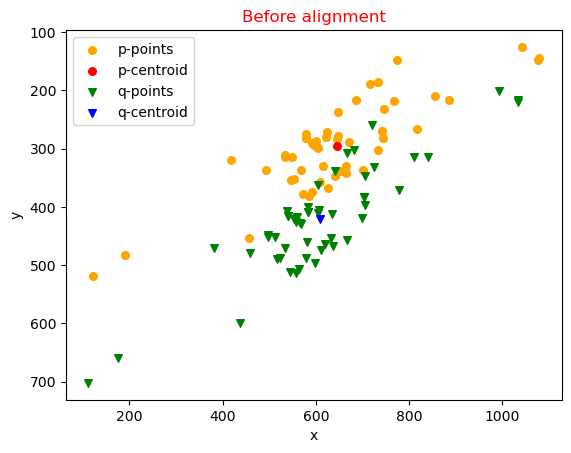

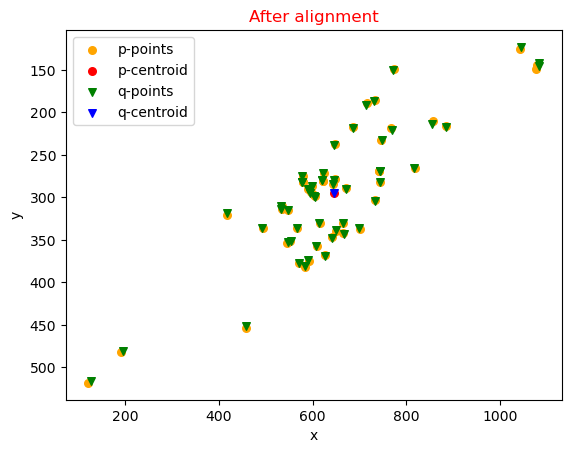

In [13]:
wsi_reg.plot_aligned_points(p=p_points,
                            q=q_points,
                            S=S,
                            R=R,
                            T=T)

In [14]:
source_reg = wsi_reg.image_registration(target=imgHE.tile_grayscale, 
                                        source=imgGI.tile_grayscale,
                                        S=S,
                                        R=R,
                                        T=T)

100%|█████████████████████████████████████████| 900/900 [00:13<00:00, 66.74it/s]


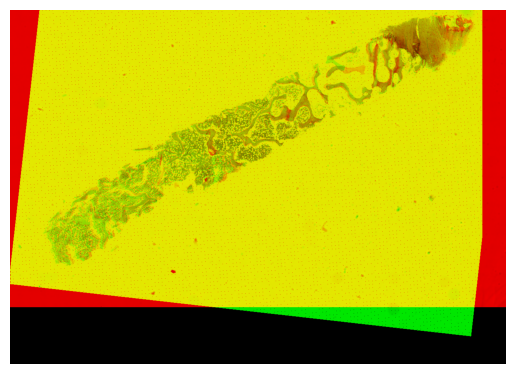

In [15]:
merged_img = wsi_reg.merge_registered_imgs(target=imgHE.tile_grayscale,
                                   source_reg=source_reg)

plt.imshow(merged_img)
plt.axis('off')
plt.show()

## Pyramidal alignment

In [16]:
REF_LEVEL = 6 # level where the gloab alignment is performed
LEVEL = [5, 4, 3, 2, 1, 0]
TOP_LEFT = [(500, 500), (1400, 1400), (3000, 3000), (6000, 6000), (12000, 12000), (24000, 24000)]
DIMS = (512, 512)

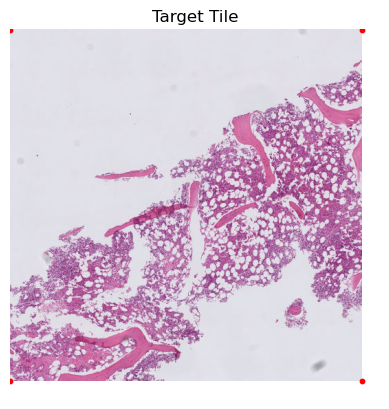

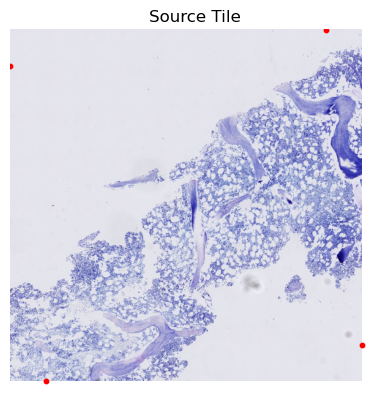

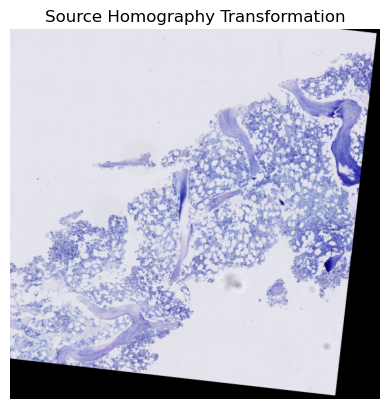

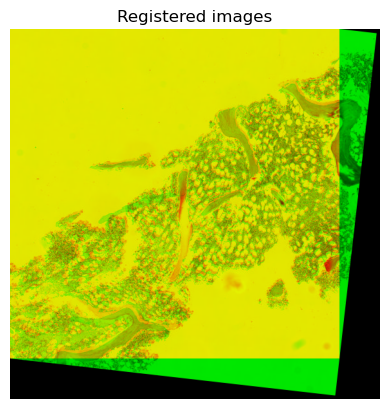

In [17]:
reg_img5 = wsi_reg.pyramid_alignment(level=LEVEL[0], 
                                     dims=DIMS, 
                                     top_left=TOP_LEFT[0], 
                                     R=R, 
                                     S=S, 
                                     T=T, 
                                     ref_level=REF_LEVEL, 
                                     plot=True)

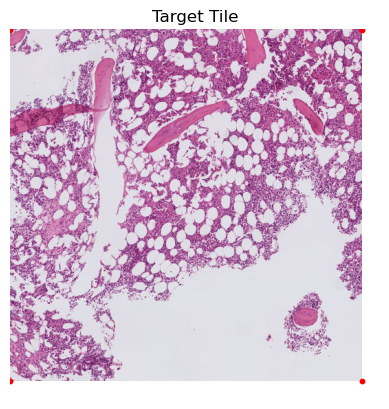

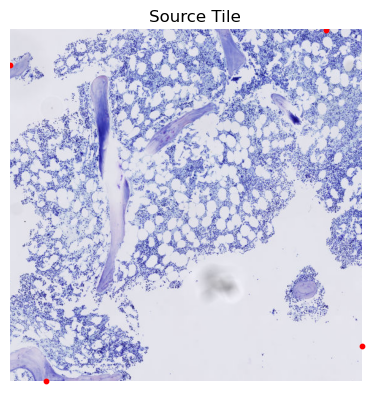

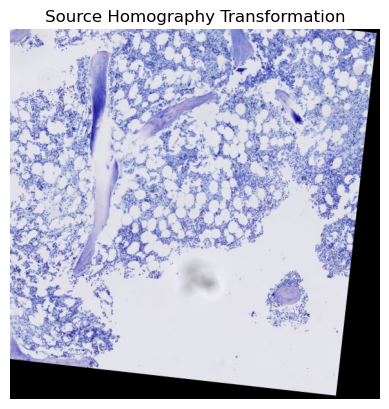

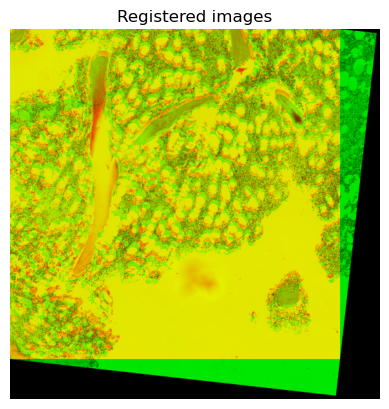

In [18]:
reg_img4 = wsi_reg.pyramid_alignment(level=LEVEL[1], 
                                     dims=DIMS, 
                                     top_left=TOP_LEFT[1], 
                                     R=R, 
                                     S=S, 
                                     T=T, 
                                     ref_level=REF_LEVEL, 
                                     plot=True)

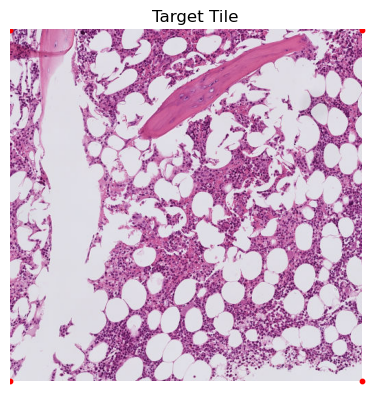

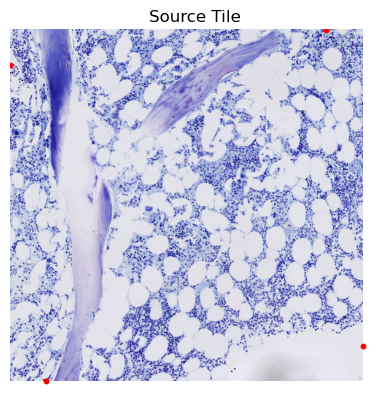

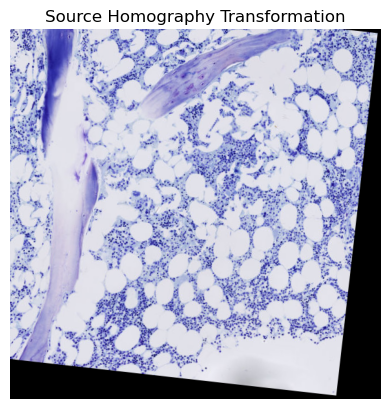

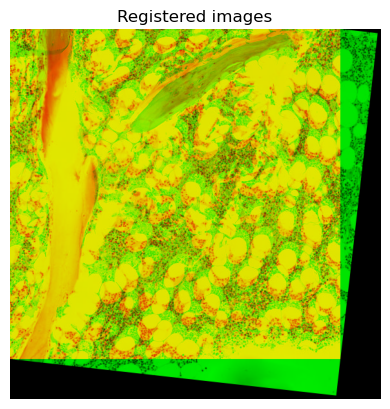

In [19]:
reg_img3 = wsi_reg.pyramid_alignment(level=LEVEL[2], 
                                     dims=DIMS, 
                                     top_left=TOP_LEFT[2], 
                                     R=R, 
                                     S=S, 
                                     T=T, 
                                     ref_level=REF_LEVEL, 
                                     plot=True)

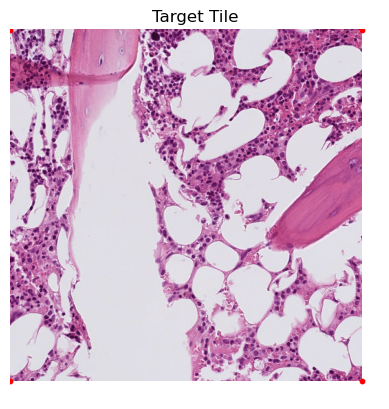

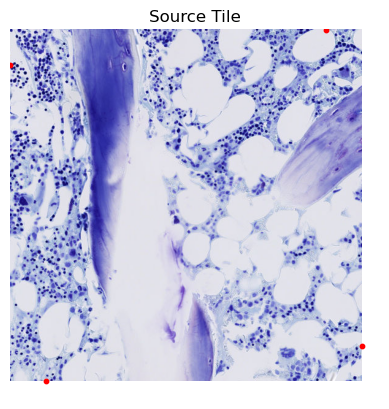

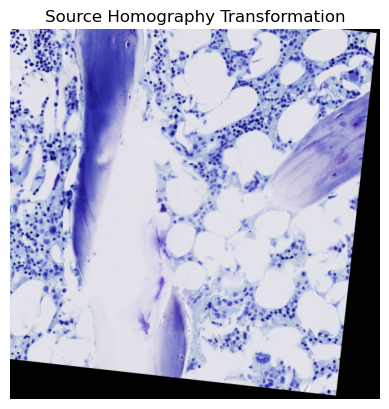

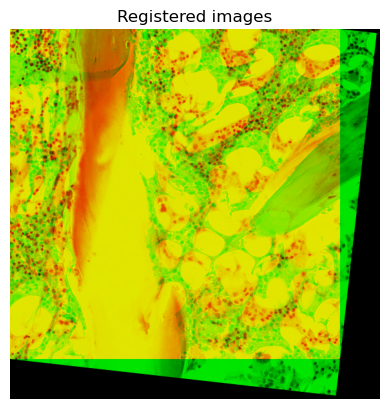

In [20]:
reg_img2 = wsi_reg.pyramid_alignment(level=LEVEL[3], 
                                     dims=DIMS, 
                                     top_left=TOP_LEFT[3], 
                                     R=R, 
                                     S=S, 
                                     T=T, 
                                     ref_level=REF_LEVEL, 
                                     plot=True)

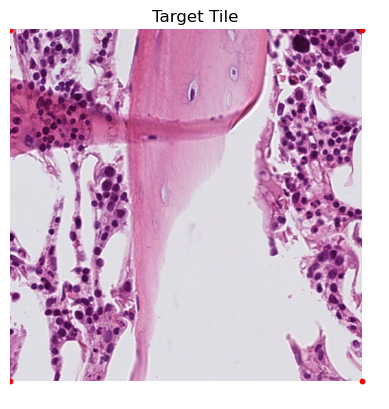

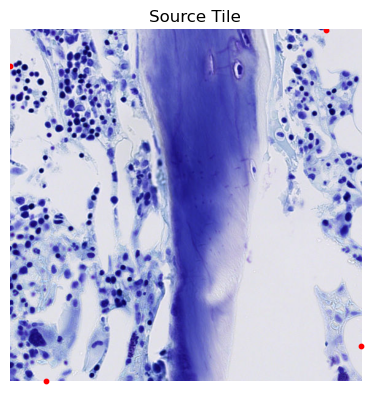

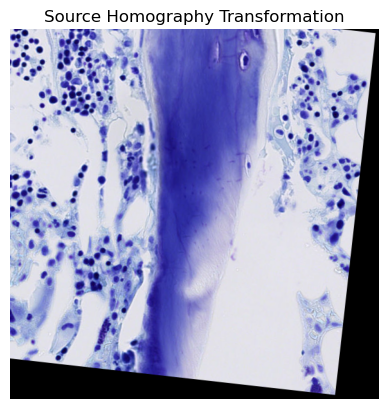

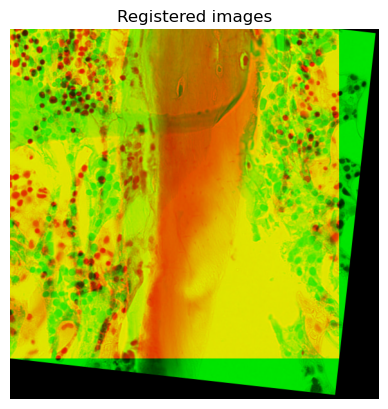

In [21]:
reg_img1 = wsi_reg.pyramid_alignment(level=LEVEL[4], 
                                     dims=DIMS, 
                                     top_left=TOP_LEFT[4], 
                                     R=R, 
                                     S=S, 
                                     T=T, 
                                     ref_level=REF_LEVEL, 
                                     plot=True)

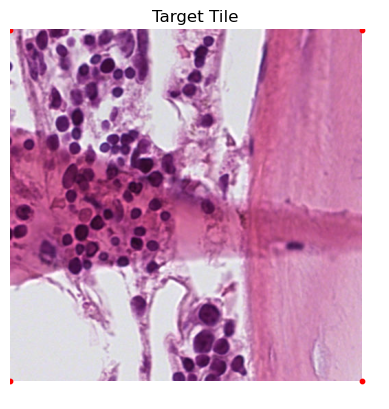

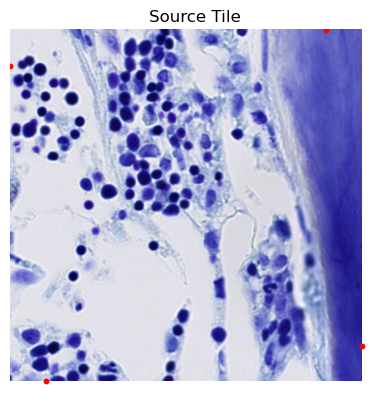

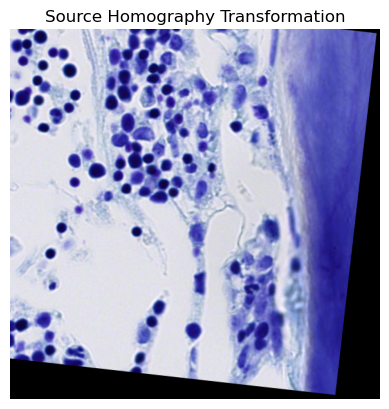

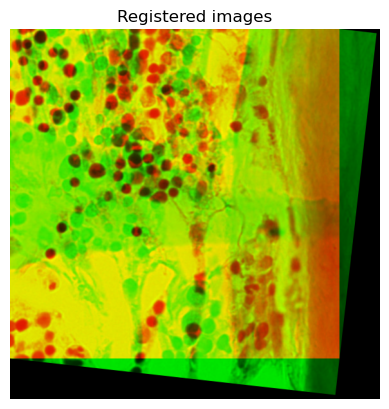

In [22]:
reg_img0 = wsi_reg.pyramid_alignment(level=LEVEL[5], 
                                     dims=DIMS, 
                                     top_left=TOP_LEFT[5], 
                                     R=R, 
                                     S=S, 
                                     T=T, 
                                     ref_level=REF_LEVEL, 
                                     plot=True)

## Local iterative registration

Select top-left corners to cover the great majority of the image

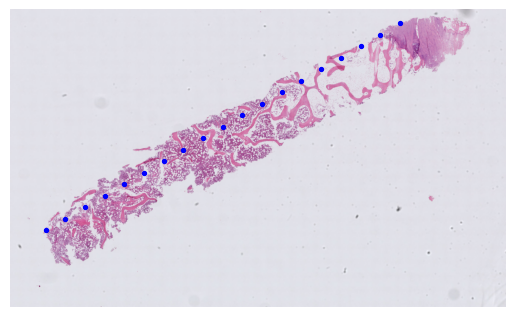

In [57]:
plt.imshow(imgHE.tile)
x = np.arange(90, 1000, 50)
y = -7/12 * x +7350/12
plt.scatter(x, y, s=8, c='blue')
plt.axis('off')
plt.show()

In [24]:
LEVEL_START = 6
LEVEL_STOP = 2
#TOP_LEFT_START = (310, 430)
TOP_LEFT_START = (int(y[3]), int(x[3]))
TILE_SIZE = (512, 512)

For each selected top-left corner, perform both static and iterative registration

In [25]:
PATH = '/home/filippo/Documenti/Ricerca/Registration/Images/Static_VS_Iterative/'

for idx in tqdm.tqdm(range(len(y))):
    
    # Evaluate the transformation parameters R, S and T for each level
    top_left = (int(y[idx]), int(x[idx]))
    parameters = wsi_reg.local_iterative_registration(level_start=LEVEL_START, 
                                                      level_stop=LEVEL_STOP, 
                                                      top_left_start=top_left, 
                                                      tile_size=TILE_SIZE,
                                                      min_match_count=4,
                                                      plot=False)
    
    # Use the LEVEL START parameters for the static pyramidal registration
    S_ref, R_ref, T_ref = parameters[f'level_{LEVEL_START}']
    static_reg_imgs = wsi_reg.stack_static_registration(ref_level=LEVEL_START, 
                                                        top_left_start=top_left, 
                                                        tile_size=TILE_SIZE, 
                                                        S=S_ref, 
                                                        R=R_ref, 
                                                        T=T_ref)
    
    # Perform iterative pyramidal registration
    iter_reg_imgs = wsi_reg.stack_iterative_registration(ref_level=LEVEL_START, 
                                                         top_left_start=top_left, 
                                                         tile_size=TILE_SIZE, 
                                                         parameters=parameters)
    
    # Save images 
    levels = np.arange(LEVEL_START-1, -1, -1) # from level start to zero
    for i, level in enumerate(levels):
        path = os.path.join(PATH, f'level_{level}') 
        if not os.path.exists(path):
            os.makedirs(path)
        plt.imsave(os.path.join(path, f'static_{idx}.png'), static_reg_imgs[i])
        plt.imsave(os.path.join(path, f'iterative_{idx}.png'), iter_reg_imgs[i])
        
    


  0%|                                                    | 0/19 [00:00<?, ?it/s]

{'level_6': [0.9830132027121996, array([[ 0.99359893,  0.11296534],
       [-0.11296534,  0.99359893]]), array([-183.49445295,   97.87779891])], 'level_5': [0.9905751312633836, array([[ 0.99212701,  0.12523574],
       [-0.12523574,  0.99212701]]), array([-373.19215788,  198.53664103])], 'level_4': [0.9911835197165331, array([[ 0.99219582,  0.12468943],
       [-0.12468943,  0.99219582]]), array([-748.07241067,  395.37912681])], 'level_3': [0.999897186390875, array([[ 0.99376323,  0.11151069],
       [-0.11151069,  0.99376323]]), array([-1544.39189908,   706.781751  ])]}



  5%|██▎                                         | 1/19 [00:11<03:25, 11.43s/it]

{'level_6': [0.9914023037758626, array([[ 0.99363446,  0.11265241],
       [-0.11265241,  0.99363446]]), array([-187.33038002,   92.70647387])], 'level_5': [0.990841825232089, array([[ 0.99247293,  0.12246423],
       [-0.12246423,  0.99247293]]), array([-373.51105364,  194.33709168])], 'level_4': [0.9874666580887811, array([[ 0.9923791 ,  0.12322227],
       [-0.12322227,  0.9923791 ]]), array([-735.6202887 ,  392.99140244])], 'level_3': [0.9844239808628164, array([[ 0.99312071,  0.11709504],
       [-0.11709504,  0.99312071]]), array([-1449.75671864,   751.33922787])], 'level_2': [0.9900619600269784, array([[ 0.9914467 ,  0.13051224],
       [-0.13051224,  0.9914467 ]]), array([-2976.17764771,  1656.13299184])]}



 11%|████▋                                       | 2/19 [00:24<03:30, 12.41s/it]

{'level_6': [0.9887615381463176, array([[ 0.9935917 ,  0.11302892],
       [-0.11302892,  0.9935917 ]]), array([-186.13050792,   94.04293292])], 'level_5': [1.0030092975548603, array([[ 0.99291963,  0.11878805],
       [-0.11878805,  0.99291963]]), array([-391.22238404,  185.70801172])], 'level_4': [0.9961471167463551, array([[ 0.99282371,  0.11958716],
       [-0.11958716,  0.99282371]]), array([-761.54762874,  378.36321138])]}



 16%|██████▉                                     | 3/19 [00:37<03:23, 12.71s/it]

Error: Not enough matches are found - 1/4
 If possible, try to reduce min_match_count
{'level_6': [0.9851760592794772, array([[ 0.99369097,  0.11215281],
       [-0.11215281,  0.99369097]]), array([-184.22097936,   96.22675554])], 'level_5': [0.9983681853198895, array([[ 0.99308764,  0.11737523],
       [-0.11737523,  0.99308764]]), array([-384.2763293 ,  185.37495027])], 'level_4': [1.002969865274507, array([[ 0.99386074,  0.11063832],
       [-0.11063832,  0.99386074]]), array([-776.01679598,  347.83029909])], 'level_3': [0.9902795875469903, array([[ 0.99211753,  0.12531084],
       [-0.12531084,  0.99211753]]), array([-1500.00353486,   799.96196283])]}



 21%|█████████▎                                  | 4/19 [00:51<03:19, 13.33s/it]

{'level_6': [0.9872102786455413, array([[ 0.9936377 ,  0.11262384],
       [-0.11262384,  0.9936377 ]]), array([-185.20438692,   94.93522098])], 'level_5': [0.9953561395999735, array([[ 0.99278342,  0.11992111],
       [-0.11992111,  0.99278342]]), array([-380.91233737,  191.10125703])], 'level_4': [0.9910604946265663, array([[ 0.99277815,  0.11996478],
       [-0.11996478,  0.99277815]]), array([-749.8894003 ,  386.51283785])], 'level_3': [0.9832795625796549, array([[ 0.99396083,  0.10973547],
       [-0.10973547,  0.99396083]]), array([-1437.62239691,   736.04591041])], 'level_2': [0.9829041066160853, array([[ 0.99282443,  0.11958114],
       [-0.11958114,  0.99282443]]), array([-2902.58512233,  1573.36220517])]}



 26%|███████████▌                                | 5/19 [01:06<03:11, 13.70s/it]

{'level_6': [0.9886274003995563, array([[ 0.99377376,  0.11141688],
       [-0.11141688,  0.99377376]]), array([-185.34479784,   93.94168303])], 'level_5': [0.9718302839080856, array([[ 0.99425208,  0.10706452],
       [-0.10706452,  0.99425208]]), array([-344.67097188,  191.29189438])], 'level_4': [1.0095646724233698, array([[ 0.99278082,  0.11994266],
       [-0.11994266,  0.99278082]]), array([-800.02806951,  368.58391065])], 'level_3': [0.9900375216306017, array([[ 0.99349031,  0.11391662],
       [-0.11391662,  0.99349031]]), array([-1483.3959828 ,   749.87833405])]}



 32%|█████████████▉                              | 6/19 [01:19<02:56, 13.61s/it]

{'level_6': [0.9856645395516066, array([[ 0.99358641,  0.11307541],
       [-0.11307541,  0.99358641]]), array([-184.87641374,   96.30121232])], 'level_5': [0.9405947051013619, array([[ 0.99461199,  0.10366765],
       [-0.10366765,  0.99461199]]), array([-305.15436363,  210.1409271 ])], 'level_4': [1.003245313570325, array([[ 0.99471283,  0.10269561],
       [-0.10269561,  0.99471283]]), array([-761.19095901,  333.58719465])], 'level_3': [0.9943909356935013, array([[ 0.9955093 ,  0.09466377],
       [-0.09466377,  0.9955093 ]]), array([-1457.36019   ,   653.13127182])], 'level_2': [0.9972769050416638, array([[ 0.99183295,  0.12754375],
       [-0.12754375,  0.99183295]]), array([-3110.86978656,  1603.62274343])]}



 37%|████████████████▏                           | 7/19 [01:33<02:45, 13.82s/it]

{'level_6': [0.9882201536782701, array([[ 0.99357365,  0.1131875 ],
       [-0.1131875 ,  0.99357365]]), array([-185.89823453,   94.42525025])]}



 42%|██████████████████▌                         | 8/19 [01:45<02:23, 13.01s/it]

{'level_6': [0.9881475934926883, array([[ 0.99360819,  0.11288387],
       [-0.11288387,  0.99360819]]), array([-185.82785535,   94.62439336])], 'level_5': [0.9863609059866193, array([[ 0.99398545,  0.10951224],
       [-0.10951224,  0.99398545]]), array([-366.3994516 ,  188.28764765])], 'level_4': [0.9841749613018268, array([[ 0.9932424 ,  0.11605834],
       [-0.11605834,  0.9932424 ]]), array([-739.75123954,  395.04126597])], 'level_3': [0.9694628747442374, array([[ 0.99398179,  0.1095454 ],
       [-0.1095454 ,  0.99398179]]), array([-1396.29304643,   813.42270468])], 'level_2': [0.9792679902377771, array([[ 0.99788365,  0.06502484],
       [-0.06502484,  0.99788365]]), array([-2572.13999364,  1200.66746344])]}



 47%|████████████████████▊                       | 9/19 [01:59<02:13, 13.39s/it]

{'level_6': [0.9870845598043296, array([[ 0.99373066,  0.11180057],
       [-0.11180057,  0.99373066]]), array([-184.92082722,   94.84969212])], 'level_5': [0.9854198240165394, array([[ 0.99400459,  0.10933832],
       [-0.10933832,  0.99400459]]), array([-365.34379474,  189.5924152 ])], 'level_4': [0.9824011760630079, array([[ 0.99373442,  0.11176714],
       [-0.11176714,  0.99373442]]), array([-729.40162026,  390.50906068])], 'level_3': [0.9944726332949021, array([[ 0.99242314,  0.12286703],
       [-0.12286703,  0.99242314]]), array([-1549.67206125,   781.31635852])], 'level_2': [1.003686769898781, array([[ 0.99542839,  0.0955108 ],
       [-0.0955108 ,  0.99542839]]), array([-2964.35959827,  1276.17389332])]}



 53%|██████████████████████▋                    | 10/19 [02:14<02:05, 13.98s/it]

{'level_6': [0.9809836482313898, array([[ 0.9935466 ,  0.11342465],
       [-0.11342465,  0.9935466 ]]), array([-182.92436455,   99.40441124])], 'level_5': [0.984065210929995, array([[ 0.99365487,  0.11247224],
       [-0.11247224,  0.99365487]]), array([-368.10482887,  194.773034  ])], 'level_4': [0.9892662784550301, array([[ 0.99311294,  0.11716093],
       [-0.11716093,  0.99311294]]), array([-756.86054146,  387.33097504])], 'level_3': [0.9860915905961273, array([[ 0.99249283,  0.12230283],
       [-0.12230283,  0.99249283]]), array([-1522.56156289,   810.93992274])], 'level_2': [0.9976172261897935, array([[ 0.9924486 ,  0.12266123],
       [-0.12266123,  0.9924486 ]]), array([-3130.90648455,  1530.50954583])]}



 58%|████████████████████████▉                  | 11/19 [02:30<01:56, 14.50s/it]

{'level_6': [0.9871796793407468, array([[ 0.99361443,  0.11282888],
       [-0.11282888,  0.99361443]]), array([-185.35814479,   95.06404363])], 'level_5': [0.9791323904913528, array([[ 0.9938002 ,  0.11118074],
       [-0.11118074,  0.9938002 ]]), array([-362.23582047,  199.58428788])], 'level_4': [0.9755660955464098, array([[ 0.99413412,  0.10815425],
       [-0.10815425,  0.99413412]]), array([-710.17308396,  402.04899529])], 'level_3': [0.9793779151466026, array([[ 0.99419069,  0.10763302],
       [-0.10763302,  0.99419069]]), array([-1435.86108749,   788.87275776])]}



 63%|███████████████████████████▏               | 12/19 [02:45<01:42, 14.64s/it]

{'level_6': [0.9951196696469913, array([[ 0.99368919,  0.11216856],
       [-0.11216856,  0.99368919]]), array([-189.13706961,   90.89223026])], 'level_5': [0.9887061100581307, array([[ 0.99432219,  0.10641139],
       [-0.10641139,  0.99432219]]), array([-365.65193814,  181.98721501])], 'level_4': [0.9903221246120476, array([[ 0.9940914 ,  0.10854622],
       [-0.10854622,  0.9940914 ]]), array([-740.24722537,  364.25471907])]}



 68%|█████████████████████████████▍             | 13/19 [02:58<01:24, 14.04s/it]

{'level_6': [0.9856032806973162, array([[ 0.99390651,  0.11022635],
       [-0.11022635,  0.99390651]]), array([-183.43426961,   95.33513273])], 'level_5': [0.9871023444455725, array([[ 0.99398181,  0.10954525],
       [-0.10954525,  0.99398181]]), array([-368.15015555,  187.06970757])], 'level_4': [0.9894618390269355, array([[ 0.99348396,  0.11397198],
       [-0.11397198,  0.99348396]]), array([-753.31319664,  375.44188826])]}



 74%|███████████████████████████████▋           | 14/19 [03:10<01:07, 13.45s/it]

{'level_6': [0.9865385857396632, array([[ 0.99378938,  0.11127743],
       [-0.11127743,  0.99378938]]), array([-184.34927604,   95.1578886 ])], 'level_5': [0.9689265627146849, array([[ 0.99277452,  0.11999478],
       [-0.11999478,  0.99277452]]), array([-367.7157599 ,  224.56048604])]}



 79%|█████████████████████████████████▉         | 15/19 [03:22<00:52, 13.08s/it]

{'level_6': [0.9897056196628455, array([[ 0.99362298,  0.11275363],
       [-0.11275363,  0.99362298]]), array([-186.52584644,   93.57216407])], 'level_5': [0.9504893573432848, array([[ 0.99248641,  0.12235491],
       [-0.12235491,  0.99248641]]), array([-359.29938236,  259.1074764 ])]}



 84%|████████████████████████████████████▏      | 16/19 [03:34<00:38, 12.79s/it]

{'level_6': [0.9883551193772698, array([[ 0.99353424,  0.11353287],
       [-0.11353287,  0.99353424]]), array([-186.05704853,   94.44375592])], 'level_5': [0.9487947078510569, array([[ 0.99035291,  0.1385681 ],
       [-0.1385681 ,  0.99035291]]), array([-389.56935243,  275.15662384])]}



 89%|██████████████████████████████████████▍    | 17/19 [03:46<00:25, 12.54s/it]

{'level_6': [0.9882528538259017, array([[ 0.99357039,  0.11321611],
       [-0.11321611,  0.99357039]]), array([-185.93502309,   94.41665777])], 'level_5': [0.9497804690399831, array([[ 0.98801428,  0.15436252],
       [-0.15436252,  0.98801428]]), array([-419.09851797,  283.50130048])], 'level_4': [0.962132194608925, array([[ 0.99153622,  0.1298304 ],
       [-0.1298304 ,  0.99153622]]), array([-771.49091659,  491.96129945])], 'level_3': [0.9926632479535982, array([[ 0.99388709,  0.11040131],
       [-0.11040131,  0.99388709]]), array([-1481.34097321,   737.03872649])], 'level_2': [1.0060682874465763, array([[ 0.9938688 ,  0.11056584],
       [-0.11056584,  0.9938688 ]]), array([-3018.5516405 ,  1287.74451119])]}



 95%|████████████████████████████████████████▋  | 18/19 [04:00<00:12, 12.99s/it]

Error: Not enough matches are found - 2/4
 If possible, try to reduce min_match_count
{'level_6': [0.986248538670107, array([[ 0.99340461,  0.1146616 ],
       [-0.1146616 ,  0.99340461]]), array([-185.77929456,   96.61797356])], 'level_5': [0.9673223639147261, array([[ 0.99082289,  0.13516659],
       [-0.13516659,  0.99082289]]), array([-399.15170123,  236.71720641])], 'level_4': [0.9745221736595241, array([[ 0.98763647,  0.15676162],
       [-0.15676162,  0.98763647]]), array([-887.4225811 ,  474.58283485])], 'level_3': [0.9996714846882365, array([[ 0.99578954,  0.09166892],
       [-0.09166892,  0.99578954]]), array([-1342.64713668,   616.33806801])]}


100%|███████████████████████████████████████████| 19/19 [04:14<00:00, 13.40s/it]


## Compare Static vs Iterative with Mutual Image Information

In [43]:
LEVEL = [0, 1, 2, 3, 4, 5]

static_mean_mii = []
iter_mean_mii = []
static_std_mii = []
iter_std_mii = []

for level in LEVEL:
    path = f'/home/filippo/Documenti/Ricerca/Registration/Images/Static_VS_Iterative/level_{level}/'
    num = int(len(os.listdir(path)) / 2)
    imgs_iter = []
    imgs_static = []
    for i in range(num):
        filename_iter = os.path.join(path, f'iterative_{i}.png')
        filename_static = os.path.join(path, f'static_{i}.png')
        img_iter = Image.open(filename_iter)
        img_static = Image.open(filename_static)
        imgs_iter.append(np.asarray(img_iter))
        imgs_static.append(np.asarray(img_static))
    mii_1 = []
    mii_2 = []
    for i in range(len(imgs_iter)):
        mii_1.append(wsi_reg.mii_evaluation(imgs_iter[i]))
        mii_2.append(wsi_reg.mii_evaluation(imgs_static[i]))
    
    iter_mean_mii.append(np.mean(mii_1))
    static_mean_mii.append(np.mean(mii_2))
    iter_std_mii.append(np.std(mii_1))
    static_std_mii.append(np.std(mii_2))


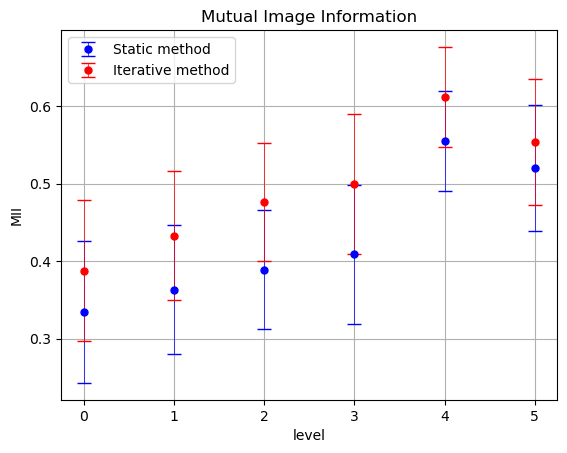

In [53]:
# Scatter plot with y-errors
plt.errorbar(LEVEL, 
             static_mean_mii, 
             yerr=static_std_mii, 
             fmt='o', 
             capsize=5, markersize=5, color='blue', ecolor='blue', label='Static method', elinewidth=0.5)

plt.errorbar(LEVEL, 
             iter_mean_mii, 
             yerr=static_std_mii, 
             fmt='o', 
             capsize=5, markersize=5, color='red', ecolor='red', label='Iterative method', elinewidth=0.5)

# Aggiungi etichette e titolo
plt.xlabel('level')
plt.ylabel('MII')
plt.grid()
plt.title('Mutual Image Information')

# Aggiungi legenda
plt.legend()

# Mostra il plot
plt.show()

In [72]:
for level in tqdm.tqdm(LEVEL):
    for idx in range(num):
        img1 = Image.open(f'/home/filippo/Documenti/Ricerca/Registration/Images/Static_VS_Iterative/level_{level}/iterative_{idx}.png')
        img2 = Image.open(f'/home/filippo/Documenti/Ricerca/Registration/Images/Static_VS_Iterative/level_{level}/static_{idx}.png')

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        ax1.imshow(img1)
        ax1.set_title(f'Iterative method-Level {level}')
        ax1.axis('off')

        ax2.imshow(img2)
        ax2.set_title(f'Static method-Level {level}')
        ax2.axis('off')
        
        filename = f'/home/filippo/Documenti/Ricerca/Presentazioni/Gennaio24Registration/Images/level_{level}_id_{idx}'
        plt.savefig(filename, bbox_inches='tight')
        plt.close()
        
        

100%|█████████████████████████████████████████████| 6/6 [00:53<00:00,  8.85s/it]
